In [1]:
#Importing essential packages
from matplotlib import pyplot as plt
import pandas as pd
import netCDF4
import xarray as xr
import numpy as np
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from scipy import ndimage

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import joblib

import tensorflow as tf
from tensorflow import keras
from keras.models import load_model

import time

from skimage.metrics import structural_similarity

In [2]:
#Check the GPU given by Colab. Tesla P100-PCIE-16GB is the best. If different one assigned shut down the kernel and restart it.
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-b27163f1-a4ff-53c2-e01e-876c568f443e)


In [3]:
#Connect to personnal google account
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Useful functions

In [4]:
# Function we use for plotting
def plot_data_img(nr, nc, data, true_data, ts, title='Plot test', name_file=None, threshold=0.01):
    '''
    Function to plot the maps of the variables
    nr : number of plot row - int
    nc : number of plot column - int
    true_data : the original data - numpy array
    ts :  indices of the maps to plot - list
    title : title of the maps plotted - string
    name_file : name to save the plot as images. - string
    threshold : value added to the array to avoid nan values when converting to logarithmic scale - int
    '''
    #The min and max value of the oiginal data are saved to have the same colorbar when plotting the maps. 
    valmin = [np.min(true_data[elem]) for elem in ts]
    valmax = [np.max(true_data[elem]) for elem in ts]
    
    fig, axes = plt.subplots(nr, nc, figsize=(20, 13))
    for t, ax, vmin, vmax in zip(ts, axes.ravel(), valmin, valmax):
      #Flip the image to see in the proper orientation
      rotate_image = ndimage.rotate(np.log(data[t]+threshold), 180)
      #Show the map with the threshold added.
      im = ax.imshow(rotate_image, vmin=np.log(vmin+threshold), vmax=np.log(vmax+threshold))
      ax.set_title(title + f" {t}", fontsize=16, fontweight='bold', fontname= 'Times New Roman')
      ax.set_ylabel('Latitude')
      ax.set_xlabel('Longitude')
      ax.axis('off')
      #displaying the colorbar and adjusting its size
      fig.colorbar(im, ax=ax, fraction=0.03, pad=0.03)
      #Adjust maps size to avoid overlapping 
      fig.tight_layout(pad=1.5)
    
    #The image is saved only if a name_file is given to the function
    if name_file != None:
      #Adjust the size of the image to reduce white space aroung the image
      fig.set_size_inches(15,2.5)
      plt.savefig("/content/drive/MyDrive/Wildfires_IRP/Figures/"+name_file)
    
    plt.show()

# rotated_img = ndimage.rotate(np.log(data[37]+threshold), 180)
# im = ax.imshow(rotated_img, vmin=np.log(vmin+threshold), vmax=np.log(vmax+threshold))

def plot_data_img_diff(nr, nc, data1, data2, ts, title='Plot test', name_file=None):
  '''
  Function to plot the difference between original maps and maps predicted by the models
  nr : number of plot row - int
  nc : number of plot column - int
  data1 : the original data - numpy array
  data2 : predictions - numpy array
  ts :  indices of the maps to plot - list
  title : title of the maps plotted - string
  name_file : name to save the plot as images. - string
  '''
  fig, axes = plt.subplots(nr, nc, figsize=(20, 13))
  for t, ax in zip(ts, axes.ravel()):
    #Flip the image to see in the proper orientation
    rotate_image = ndimage.rotate(data2[t] - data1[t], 180)
    #Show the map with the threshold in a gray scale.
    im = ax.imshow(rotate_image, cmap='gray')
    ax.set_title(title + f" {t}")
    ax.set_ylabel('Latitude')
    ax.set_xlabel('Longitude')
    #displaying the colorbar and adjusting its size
    fig.colorbar(im, ax=ax, fraction=0.03, pad=0.03)
    #Adjust maps size to avoid overlapping 
    fig.tight_layout(pad=1.5)
  
  #The image is saved only if a name_file is given to the function
  if name_file != None:
    #Adjust the size of the image to reduce white space aroung the image
    fig.set_size_inches(15,2.5) # this is use to when save the figures to avoid white space above and under
    plt.savefig("/content/drive/MyDrive/Wildfires_IRP/Figures/"+name_file, dpi=300)

  plt.show()

def Select_d_previous_month(d, data):
  '''
  Function that re organized the original data into array of d consecutive previous months 
  d : target number of consecutive month to consider - int 
  data : original data - numpy array

  returns :
  x_data : array of sequences containing d previous months, meaning shape of (d, ...) 
  y_data : array of sequences containing futur months, meaning shape of (1, ...)
  '''
  # set the number of previous month you want to take
  nl = [data[val:val+d] for val in range(0,len(data)-d)]
  x_data = np.asarray(nl)

  y_data = data[d:]

  return x_data, y_data

def Select_previous_future_months(d_previous_months, n_futur_months, data):
  '''
  Function that re organized the original data into array of d consecutive previous months and n consecutive futur months
  d_previous_months : target number of consecutive month to consider - int
  n_futur_months : target number of consecutive month to consider - int 
  data : original data - numpy array

  returns :
  x_data : array of sequences containing d previous months, meaning shape of (d_previous_months, ...) 
  y_data : array of sequences containing n futur months, meaning shape of (n_futur_months, ...) 
  '''
  # set the number of previous month you want to take
  nl = [data[val:val+d_previous_months] for val in range(0,len(data)+1 - d_previous_months - n_futur_months)]
  x_data = np.asarray(nl)

  fl = [data[elem:elem+n_futur_months] for elem in range(d_previous_months,len(data) + 1 -n_futur_months)]
  y_data =  np.asarray(fl)

  return x_data, y_data

### Import the scaled data

In [5]:
area_burnt_pt = np.load("/content/drive/MyDrive/Wildfires_IRP/data/pT/monthly_dta_pT_scaled.npy")
T_data_pt = np.load("/content/drive/MyDrive/Wildfires_IRP/data/pT/monthly_T_pT_scaled.npy")
veg_data_pt = np.load("/content/drive/MyDrive/Wildfires_IRP/data/pT/monthly_veg_pT_scaled.npy")
moist_data_pt = np.load("/content/drive/MyDrive/Wildfires_IRP/data/pT/monthly_moist_pT_scaled.npy")

In [6]:
area_burnt_pt_m = area_burnt_pt.copy()
T_data_pt_m = T_data_pt.copy()
veg_data_pt_m = veg_data_pt.copy()
moist_data_pt_m = moist_data_pt.copy() 

### Import the compressors

In [7]:
# Load compressor
area_compressor = load_model('/content/drive/MyDrive/Wildfires_IRP/compressors/CAE_areaburnt')
moist_compressor = load_model('/content/drive/MyDrive/Wildfires_IRP/compressors/CAE_moist')
T_compressor = load_model('/content/drive/MyDrive/Wildfires_IRP/compressors/CAE_temp')
veg_compressor = load_model('/content/drive/MyDrive/Wildfires_IRP/compressors/CAE_veg')

In [8]:
area_encoder = area_compressor.get_layer(index=0)
moist_encoder = moist_compressor.get_layer(index=0)
temp_encoder = T_compressor.get_layer(index=0)
veg_encoder = veg_compressor.get_layer(index=0)

area_decoder = area_compressor.get_layer(index=1)
moist_decoder = moist_compressor.get_layer(index=1)
temp_decoder = T_compressor.get_layer(index=1)
veg_decoder = veg_compressor.get_layer(index=1)

### Load the models

In [9]:
# uploading the best models found in 'Predictions' notebooks
multi_CAE_LSTM_12to12 = load_model('/content/drive/MyDrive/Wildfires_IRP/model/Multi_CAE_LSTM/multi_CAE_LSTM_12to12.h5')
multi_CNN_LSTM_12to12 = load_model('/content/drive/MyDrive/Wildfires_IRP/model/Multi_CNN_LSTM/multi_CNN_LSTM_12to12.h5')

### Applying the Land mask

In [10]:
land_mask = np.load("/content/drive/MyDrive/Wildfires_IRP/data/land_mask.npy")

In [11]:
land_mask[land_mask==0] = -1

In [12]:
#All water points (corressponding to -1 values in Landmask) are set to -0.01
for i in range(360):
  area_burnt_pt_m[i][land_mask==-1] = -0.01
  T_data_pt_m[i][land_mask==-1] = -0.01
  veg_data_pt_m[i][land_mask==-1] = -0.01
  moist_data_pt_m[i][land_mask==-1] = -0.01

### Fine Tuning and predictions multi CAE LSTM - 12 to 12

##### Predictions without fine tuning

In [13]:
#Compress the data
area_burnt_ptc = area_encoder.predict(area_burnt_pt[48:60])
T_data_ptc = temp_encoder.predict(T_data_pt[48:60])
veg_data_ptc = veg_encoder.predict(veg_data_pt[48:60])
moist_data_ptc = moist_encoder.predict(moist_data_pt[48:60])

In [14]:
print('Shape of the data (area burnt) : ', area_burnt_ptc.shape)
print('Shape of the data (temperature) : ', T_data_ptc.shape)
print('Shape of the data (vegetation density) : ', veg_data_ptc.shape)
print('Shape of the data (soil moisture) : ', moist_data_ptc.shape)

Shape of the data (area burnt) :  (12, 15)
Shape of the data (temperature) :  (12, 15)
Shape of the data (vegetation density) :  (12, 15)
Shape of the data (soil moisture) :  (12, 15)


In [15]:
#Concatenate them on the second axis
data_wft = np.concatenate([area_burnt_ptc, moist_data_ptc, T_data_ptc, veg_data_ptc], axis=1)
data_wft.shape

(12, 60)

In [16]:
start = time.time()
previous_month = 12

pred_best_CAE_pT_wft = list(data_wft[-previous_month:])

while len(pred_best_CAE_pT_wft) < previous_month+300:
  pred1 = multi_CAE_LSTM_12to12.predict(np.reshape(pred_best_CAE_pT_wft[-previous_month:], newshape=(1,previous_month,60)))
  preds1 = np.reshape(pred1, newshape=(previous_month,60))
  for i in range(previous_month):
    pred_best_CAE_pT_wft.append(preds1[i])

fpred_bestCAE__PT_wft = np.asarray(pred_best_CAE_pT_wft)[12:]

cae_area_burnt_pred_pT_wft = np.squeeze(area_decoder.predict(np.squeeze(fpred_bestCAE__PT_wft[:, 0:15])))
cae_moist_pred_pT_wft = np.squeeze(moist_decoder.predict(np.squeeze(fpred_bestCAE__PT_wft[:, 15:30])))
cae_temp_pred_pT_wft = np.squeeze(temp_decoder.predict(np.squeeze(fpred_bestCAE__PT_wft[:, 30:45])))
cae_veg_pred_pT_wft = np.squeeze(veg_decoder.predict(np.squeeze(fpred_bestCAE__PT_wft[:, 45:60])))

end = time.time()

In [17]:
#Applying the land mask to the predictions to compare them to original data
for i in range(300):
  cae_area_burnt_pred_pT_wft[i][land_mask==-1] = -0.01
  cae_temp_pred_pT_wft[i][land_mask==-1] = -0.01
  cae_veg_pred_pT_wft[i][land_mask==-1] = -0.01
  cae_moist_pred_pT_wft[i][land_mask==-1] = -0.01

In [18]:
# Computing Relative error and SSIM for predictions
RE_bestCAE_pT_wft = np.linalg.norm(cae_area_burnt_pred_pT_wft - area_burnt_pt_m[60:]) / 6468

sumRE_bestCAE_wft = np.cumsum([np.linalg.norm(elem2 - elem) / 6468 for elem, elem2 in zip(cae_area_burnt_pred_pT_wft, area_burnt_pt_m[60:])])
ssim_bestCAE_wtf = [structural_similarity(elem1, elem2) for elem1, elem2 in zip(cae_area_burnt_pred_pT_wft, area_burnt_pt_m[60:])]

results_bestCAE_pT_wft = {'Time for predictions (s)': round(end - start, 3), 
          #  'relative mse new way':  np.mean(relative_mse_multi_CAE_LSTM_6to6_nw),
           'relative error':  RE_bestCAE_pT_wft,
           'mean SSIM' : round(np.mean(ssim_bestCAE_wtf)*100, 2)
          }

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  import sys


____________ Real images of area burnt________________


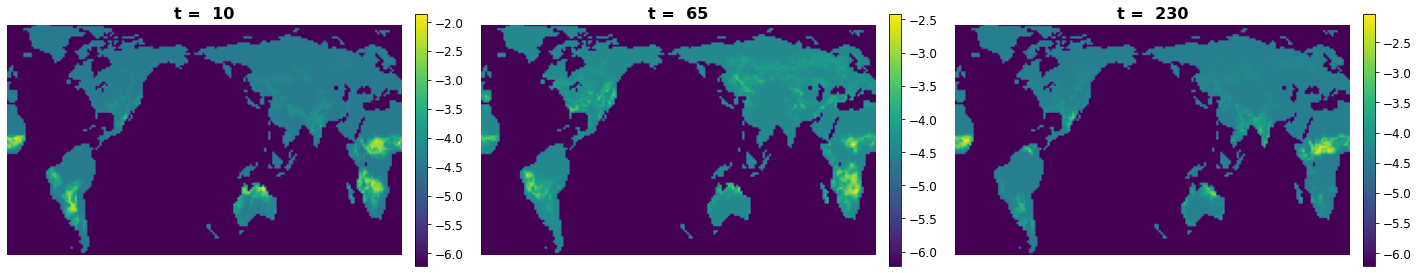

____________ Predictions multi CAE LSTM 12 to 12 _____________ 


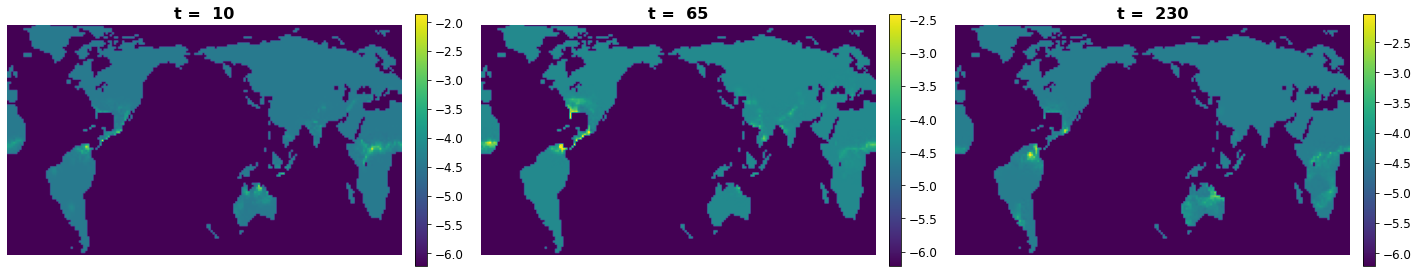

____________ Difference between both _____________ 


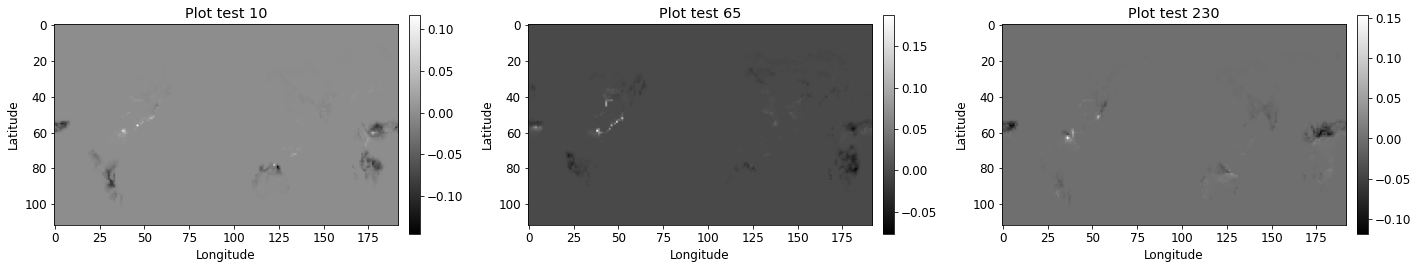

In [20]:
#Area burnt
plt.rcParams.update({'font.size': 12})
print("____________ Real images of area burnt________________")
plot_data_img(1, 3, data = area_burnt_pt_m[60:], true_data=area_burnt_pt_m[60:], ts=[10, 65, 230], title='t = ', threshold = 0.012)

print("____________ Predictions multi CAE LSTM 12 to 12 _____________ ")
plot_data_img(1, 3, data = cae_area_burnt_pred_pT_wft, true_data= area_burnt_pt_m[60:], ts = [10, 65, 230], title='t = ', threshold = 0.012)

print("____________ Difference between both _____________ ")
plot_data_img_diff(1, 3, data1 = area_burnt_pt_m[60:], data2 = cae_area_burnt_pred_pT_wft, ts = [10, 65, 230])

##### Fine tuning

In [21]:
# Prepare the data
# compressing only the 5 first years of pT (60 first foerecasts)
area_burnt_ptc = area_encoder.predict(area_burnt_pt[0:60])
T_data_ptc = temp_encoder.predict(T_data_pt[0:60])
veg_data_ptc = veg_encoder.predict(veg_data_pt[0:60])
moist_data_ptc = moist_encoder.predict(moist_data_pt[0:60])

In [22]:
#Reorganising them into arrays of p previous sequences and n futur sequences
X_area_training_pT, Y_area_training_pT = Select_previous_future_months(12, 12, area_burnt_ptc)
X_moist_training_pT, Y_moist_training_pT = Select_previous_future_months(12, 12, moist_data_ptc)
X_temp_training_pT, Y_temp_training_pT = Select_previous_future_months(12, 12, T_data_ptc)
X_veg_training_pT, Y_veg_training_pT = Select_previous_future_months(12, 12, veg_data_ptc)

In [23]:
Xdata = np.concatenate((X_area_training_pT, X_moist_training_pT, X_temp_training_pT, X_veg_training_pT), axis=2)
Ydata = np.concatenate((Y_area_training_pT, Y_moist_training_pT, Y_temp_training_pT, Y_veg_training_pT), axis=2)

In [24]:
print("Shape of X: ", Xdata.shape)
print("Shape of Y : ", Ydata.shape)

Shape of X:  (37, 12, 60)
Shape of Y :  (37, 12, 60)


In [25]:
early_stopping = keras.callbacks.EarlyStopping(monitor='loss',
                                               min_delta=0.0,
                                               patience=50,
                                               verbose=2,
                                               restore_best_weights=True)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="loss", patience=50)
multi_CAE_LSTM_12to12.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [26]:
start = time.time()
history = multi_CAE_LSTM_12to12.fit(Xdata, Ydata,
                    epochs=30,
                    verbose=1,
                    batch_size=3,
                    callbacks=[early_stopping, reduce_lr])
end = time.time()

Epoch 1/30
13/13 [==============================] - 4s 54ms/step - loss: 0.2236 - mse: 0.2236 - lr: 0.0010
Epoch 2/30
13/13 [==============================] - 1s 52ms/step - loss: 0.0826 - mse: 0.0826 - lr: 0.0010
Epoch 3/30
13/13 [==============================] - 1s 53ms/step - loss: 0.0570 - mse: 0.0570 - lr: 0.0010
Epoch 4/30
13/13 [==============================] - 1s 52ms/step - loss: 0.0494 - mse: 0.0494 - lr: 0.0010
Epoch 5/30
13/13 [==============================] - 1s 52ms/step - loss: 0.0350 - mse: 0.0350 - lr: 0.0010
Epoch 6/30
13/13 [==============================] - 1s 53ms/step - loss: 0.0304 - mse: 0.0304 - lr: 0.0010
Epoch 7/30
13/13 [==============================] - 1s 53ms/step - loss: 0.0257 - mse: 0.0257 - lr: 0.0010
Epoch 8/30
13/13 [==============================] - 1s 52ms/step - loss: 0.0251 - mse: 0.0251 - lr: 0.0010
Epoch 9/30
13/13 [==============================] - 1s 54ms/step - loss: 0.0219 - mse: 0.0219 - lr: 0.0010
Epoch 10/30
13/13 [==================

In [29]:
print(end - start)

24.35866641998291


##### Predictions fine tuned model

In [30]:
start = time.time()
previous_month = 12

pred_best_CAE_pT_ft = list(data_wft[-previous_month:])

while len(pred_best_CAE_pT_ft) < previous_month+300:
  pred1 = multi_CAE_LSTM_12to12.predict(np.reshape(pred_best_CAE_pT_ft[-previous_month:], newshape=(1,previous_month,60)))
  preds1 = np.reshape(pred1, newshape=(previous_month,60))
  for i in range(previous_month):
    pred_best_CAE_pT_ft.append(preds1[i])

fpred_bestCAE__PT_ft = np.asarray(pred_best_CAE_pT_ft)[12:]

cae_area_burnt_pred_pT_ft = np.squeeze(area_decoder.predict(np.squeeze(fpred_bestCAE__PT_ft[:, 0:15])))
cae_moist_pred_pT_ft = np.squeeze(moist_decoder.predict(np.squeeze(fpred_bestCAE__PT_ft[:, 15:30])))
cae_temp_pred_pT_ft = np.squeeze(temp_decoder.predict(np.squeeze(fpred_bestCAE__PT_ft[:, 30:45])))
cae_veg_pred_pT_ft = np.squeeze(veg_decoder.predict(np.squeeze(fpred_bestCAE__PT_ft[:, 45:60])))

end = time.time()

In [31]:
#Applying the land mask to fine tuned predictiosn to compare them to original data
#The same land mask has been applied to original data
for i in range(300):
  cae_area_burnt_pred_pT_ft[i][land_mask==-1] = -0.01
  cae_temp_pred_pT_ft[i][land_mask==-1] = -0.01
  cae_veg_pred_pT_ft[i][land_mask==-1] = -0.01
  cae_moist_pred_pT_ft[i][land_mask==-1] = -0.01

In [32]:
#Computing the 3 metrics for predictions 
RE_bestCAE_pT_ft = np.linalg.norm(cae_area_burnt_pred_pT_ft - area_burnt_pt_m[60:]) / 6468

sumRE_bestCAE_ft = np.cumsum([np.linalg.norm(elem2 - elem) / 6468 for elem, elem2 in zip(cae_area_burnt_pred_pT_ft, area_burnt_pt_m[60:])])
ssim_bestCAE_ft = [structural_similarity(elem1, elem2) for elem1, elem2 in zip(cae_area_burnt_pred_pT_ft, area_burnt_pt_m[60:])]

results_bestCAE_pT_ft = {'Time for predictions (s)': round(end - start, 3), 
          #  'relative mse new way':  np.mean(relative_mse_multi_CAE_LSTM_6to6_nw),
           'relative error':  RE_bestCAE_pT_ft,
           'mean SSIM' : round(np.mean(ssim_bestCAE_ft)*100, 2)
          }

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  


____________ Real images of area burnt________________


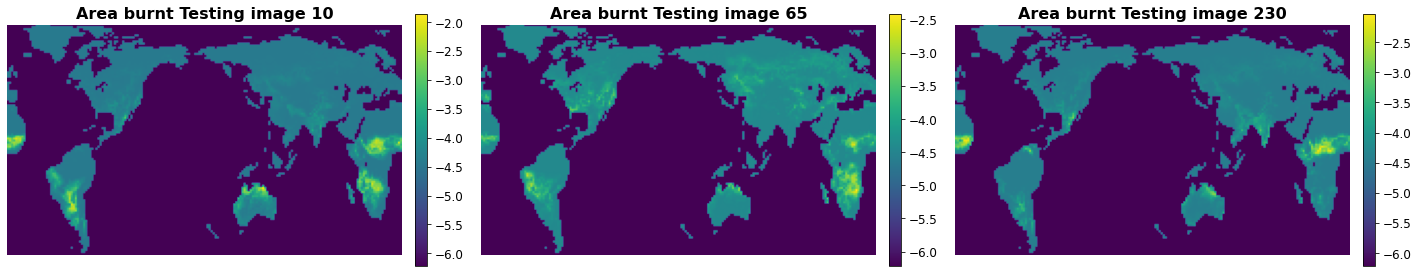

____________ Predictions multi CAE LSTM 12 to 12 _____________ 


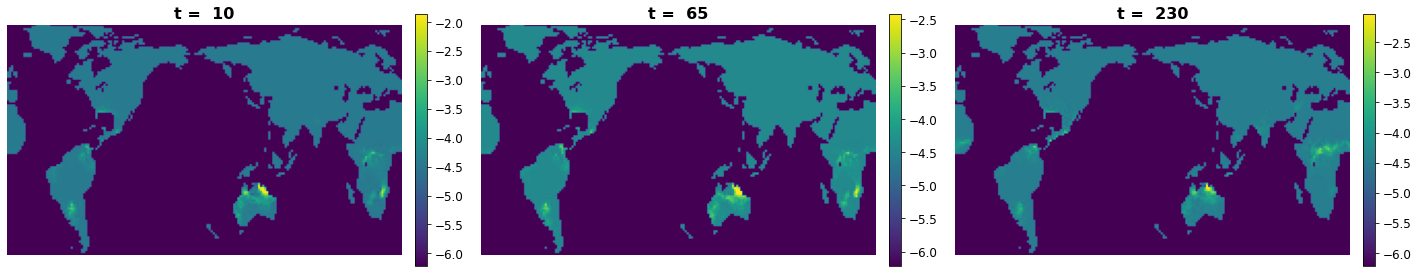

____________ Difference between both _____________ 


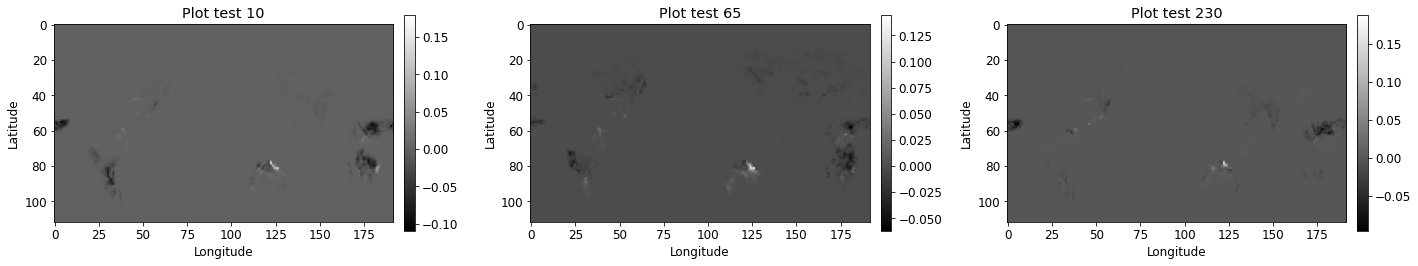

In [34]:
#Area burnt 
print("____________ Real images of area burnt________________")
plot_data_img(1, 3, data = area_burnt_pt_m[60:], true_data=area_burnt_pt_m[60:], ts=[10, 65, 230], title='Area burnt Testing image', threshold=0.012)

print("____________ Predictions multi CAE LSTM 12 to 12 _____________ ")
plot_data_img(1, 3, data = cae_area_burnt_pred_pT_ft, true_data= area_burnt_pt_m[60:], ts = [10, 65, 230], title='t = ', threshold=0.012)

print("____________ Difference between both _____________ ")
plot_data_img_diff(1, 3, data1 = area_burnt_pt_m[60:], data2 = cae_area_burnt_pred_pT_ft, ts = [10, 65, 230])

### Fine Tuning and predictions multi CNN lSTM 12 to 12

##### Results without fine tuning

In [35]:
cnn_multivar_data_pt = np.array([area_burnt_pt[48:60], moist_data_pt[48:60], T_data_pt[48:60], veg_data_pt[48:60]])
cnn_multivar_data_pt = np.expand_dims(cnn_multivar_data_pt, axis=-1)
cnn_multivar_data_pt = np.swapaxes(cnn_multivar_data_pt, axis1=0, axis2=4)
cnn_multivar_data_pt = np.squeeze(cnn_multivar_data_pt)
cnn_multivar_data_pt.shape

(12, 112, 192, 4)

In [36]:
start = time.time()

previous_month = 12

pred_multi_CNN_M2M_pT = list(cnn_multivar_data_pt[-previous_month:])

while len(pred_multi_CNN_M2M_pT) < 300 + previous_month :
  last_months = np.expand_dims(pred_multi_CNN_M2M_pT[-previous_month:], axis=0)
  prediction = np.squeeze(multi_CNN_LSTM_12to12.predict([last_months[:, :, :, :, :1], last_months[:, :, :, :, 1:2], last_months[:, :, :, :, 2:3], last_months[:, :, :, :, 3:]]))
  for i in range(previous_month):
    pred_multi_CNN_M2M_pT.append(prediction[i])

fpred_multi_cnn_M2M_pT = np.squeeze(pred_multi_CNN_M2M_pT)[previous_month:300+previous_month]
end = time.time()

In [37]:
fpred_multi_cnn_M2M_pT.shape

(300, 112, 192, 4)

In [38]:
cnn_area_burnt_pred_pT_wft = np.squeeze(fpred_multi_cnn_M2M_pT[:, :, :, 0])
cnn_moist_pred_pT_wft = np.squeeze(fpred_multi_cnn_M2M_pT[:, :, :, 1])
cnn_temp_pred_pT_wft = np.squeeze(fpred_multi_cnn_M2M_pT[:, :, :, 2])
cnn_veg_pred_pT_wft = np.squeeze(fpred_multi_cnn_M2M_pT[:, :, :, 3])

for i in range(300) :
  cnn_area_burnt_pred_pT_wft[i][land_mask==-1] = -0.01
  cnn_moist_pred_pT_wft[i][land_mask==-1] = -0.01
  cnn_veg_pred_pT_wft[i][land_mask==-1] = -0.01
  cnn_temp_pred_pT_wft[i][land_mask==-1] = -0.01

In [39]:
RE_bestCNN_wft = np.linalg.norm(area_burnt_pt_m[60:] - cnn_area_burnt_pred_pT_wft) / 6468

sumRE_bestCNN_wft = np.cumsum([np.linalg.norm(elem2 - elem) / 6468 for elem, elem2 in zip(cnn_area_burnt_pred_pT_wft, area_burnt_pt_m[60:])])
ssim_bestCNN_wft = [structural_similarity(elem1, elem2) for elem1, elem2 in zip(cnn_area_burnt_pred_pT_wft, area_burnt_pt_m[60:])]

In [40]:
results_bestCNN_wft = {'Time for predictions (s)': round(end - start, 3), 
          #  'relative mse new way':  np.mean(relative_mse_CAE_LSTM_M21_nw),
           'relative error':  RE_bestCNN_wft,
           'mean SSIM' : round(np.mean(ssim_bestCNN_wft)*100, 2)
          }

____________ Real images of area burnt________________


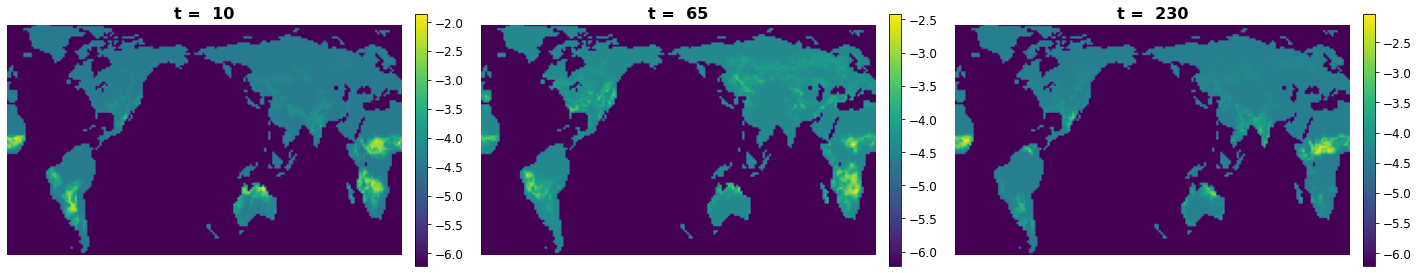

____________ Predictions multi CNN LSTM 12 to 12 _____________ 


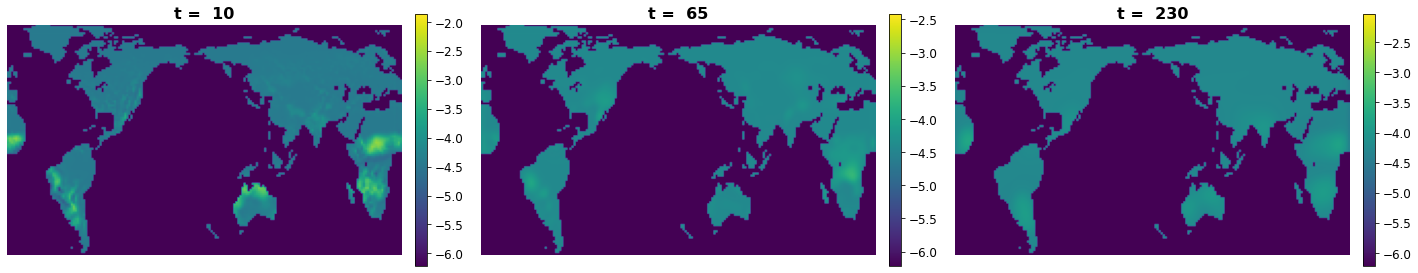

____________ Difference between both _____________ 


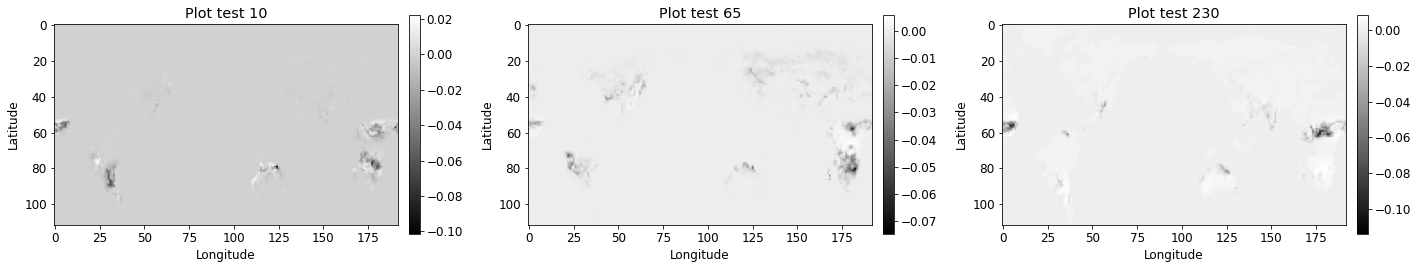

In [42]:
#Area burnt 
print("____________ Real images of area burnt________________")
plot_data_img(1, 3, data = area_burnt_pt_m[60:], true_data=area_burnt_pt_m[60:], ts=[10, 65, 230], title='t = ', threshold=0.012)

print("____________ Predictions multi CNN LSTM 12 to 12 _____________ ")
plot_data_img(1, 3, data = cnn_area_burnt_pred_pT_wft, true_data= area_burnt_pt_m[60:], ts = [10, 65, 230], title='t = ', threshold=0.012)

print("____________ Difference between both _____________ ")
plot_data_img_diff(1, 3, data1 = area_burnt_pt_m[60:], data2 = cnn_area_burnt_pred_pT_wft, ts = [10, 65, 230])

##### Fine tune

In [43]:
cnn_multivar_data_pt_train = np.array([area_burnt_pt[:60], moist_data_pt[:60], T_data_pt[:60], veg_data_pt[:60]])
cnn_multivar_data_pt_train = np.expand_dims(cnn_multivar_data_pt_train, axis=-1)
cnn_multivar_data_pt_train = np.swapaxes(cnn_multivar_data_pt_train, axis1=0, axis2=4)
cnn_multivar_data_pt_train = np.squeeze(cnn_multivar_data_pt_train)
cnn_multivar_data_pt_train.shape

(60, 112, 192, 4)

In [44]:
train, ytrain = Select_previous_future_months(d_previous_months=12, n_futur_months=12, data=cnn_multivar_data_pt_train)
print(train.shape)
print(ytrain.shape)

(37, 12, 112, 192, 4)
(37, 12, 112, 192, 4)


In [45]:
early_stopping = keras.callbacks.EarlyStopping(monitor='loss',
                                               min_delta=0.0,
                                               patience=50,
                                               verbose=1,
                                               restore_best_weights=True)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="loss", patience=50)
multi_CNN_LSTM_12to12.compile(loss=keras.losses.mse, optimizer=keras.optimizers.Adam())

In [46]:
start = time.time()
history = multi_CNN_LSTM_12to12.fit(
    [train[:, :, :, :, :1], train[:, :, :, :, 1:2], train[:, :, :, :, 2:3], train[:, :, :, :, 3:]],
    ytrain,
    batch_size = 3,
    epochs=30,
    callbacks=[early_stopping, reduce_lr]
)
end = time.time()

Epoch 1/30
13/13 [==============================] - 48s 1s/step - loss: 0.0019 - lr: 0.0010
Epoch 2/30
13/13 [==============================] - 14s 1s/step - loss: 0.0014 - lr: 0.0010
Epoch 3/30
13/13 [==============================] - 14s 1s/step - loss: 0.0013 - lr: 0.0010
Epoch 4/30
13/13 [==============================] - 14s 1s/step - loss: 0.0012 - lr: 0.0010
Epoch 5/30
13/13 [==============================] - 14s 1s/step - loss: 0.0012 - lr: 0.0010
Epoch 6/30
13/13 [==============================] - 14s 1s/step - loss: 0.0012 - lr: 0.0010
Epoch 7/30
13/13 [==============================] - 14s 1s/step - loss: 0.0012 - lr: 0.0010
Epoch 8/30
13/13 [==============================] - 14s 1s/step - loss: 0.0012 - lr: 0.0010
Epoch 9/30
13/13 [==============================] - 14s 1s/step - loss: 0.0012 - lr: 0.0010
Epoch 10/30
13/13 [==============================] - 14s 1s/step - loss: 0.0012 - lr: 0.0010
Epoch 11/30
13/13 [==============================] - 15s 1s/step - loss: 0.0012

In [47]:
print(end - start)

450.44734954833984


##### Results with fine tuning

In [48]:
start = time.time()

previous_month = 12

pred_multi_CNN_M2M_pT = list(cnn_multivar_data_pt[-previous_month:])

while len(pred_multi_CNN_M2M_pT) < 300 + previous_month :
  last_months = np.expand_dims(pred_multi_CNN_M2M_pT[-previous_month:], axis=0)
  prediction = np.squeeze(multi_CNN_LSTM_12to12.predict([last_months[:, :, :, :, :1], last_months[:, :, :, :, 1:2], last_months[:, :, :, :, 2:3], last_months[:, :, :, :, 3:]]))
  for i in range(previous_month):
    pred_multi_CNN_M2M_pT.append(prediction[i])

fpred_multi_cnn_M2M_pT = np.squeeze(pred_multi_CNN_M2M_pT)[previous_month:300+previous_month]
end = time.time()

In [50]:
cnnarea_burnt_pred_pT = np.squeeze(fpred_multi_cnn_M2M_pT[:, :, :, 0])
cnnmoist_pred_pT = np.squeeze(fpred_multi_cnn_M2M_pT[:, :, :, 1])
cnntemp_pred_pT = np.squeeze(fpred_multi_cnn_M2M_pT[:, :, :, 2])
cnnveg_pred_pT = np.squeeze(fpred_multi_cnn_M2M_pT[:, :, :, 3])

for i in range(300) :
  cnnarea_burnt_pred_pT[i][land_mask==-1] = -0.01
  cnnmoist_pred_pT[i][land_mask==-1] = -0.01
  cnnveg_pred_pT[i][land_mask==-1] = -0.01
  cnntemp_pred_pT[i][land_mask==-1] = -0.01

In [60]:
RE_bestCNN_ft = np.linalg.norm(area_burnt_pt_m[60:] - cnnarea_burnt_pred_pT) / 6468

sumRE_bestCNN_ft = np.cumsum([np.linalg.norm(elem2 - elem) / 6468 for elem, elem2 in zip(cnnarea_burnt_pred_pT, area_burnt_pt_m[60:])])
ssim_bestCNN_ft = [structural_similarity(elem1, elem2) for elem1, elem2 in zip(cnnarea_burnt_pred_pT, area_burnt_pt_m[60:])]

In [52]:
results_bestCNN_ft = {'Time for predictions (s)': round(end - start, 3), 
          #  'relative mse new way':  np.mean(relative_mse_CAE_LSTM_M21_nw),
           'relative error':  RE_bestCNN_ft,
           'mean SSIM' : round(np.mean(ssim_bestCNN_ft)*100, 2)
          }

____________ Real images of area burnt________________


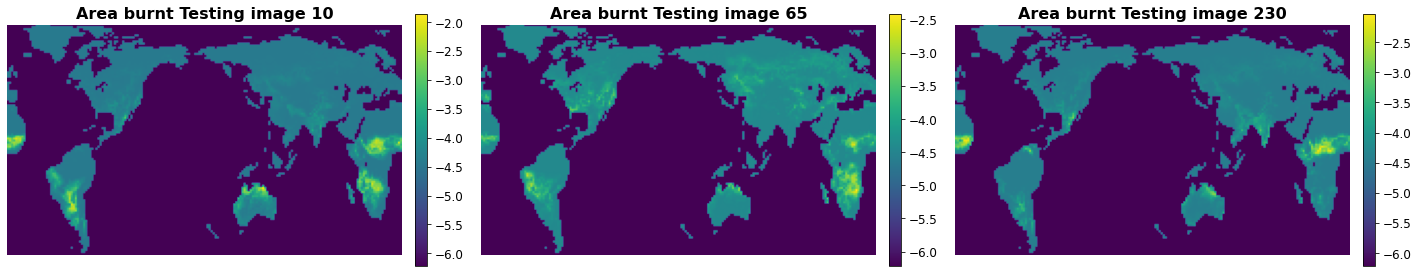

____________ Predictions multi CNN LSTM 12 to 12 _____________ 


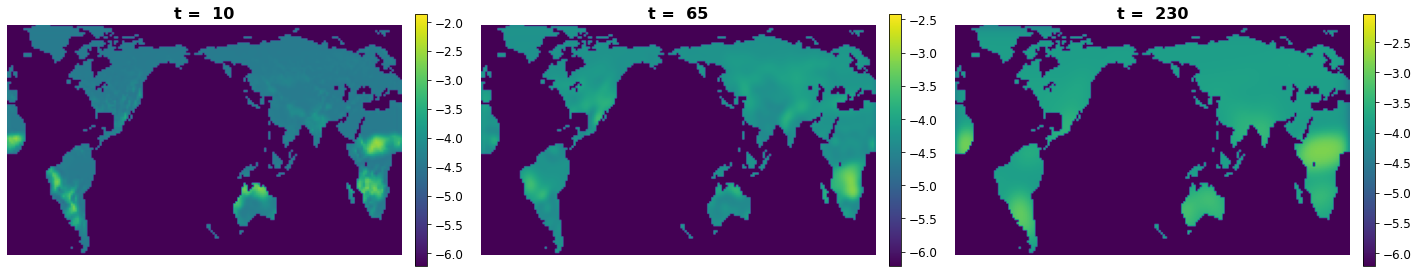

____________ Difference between both _____________ 


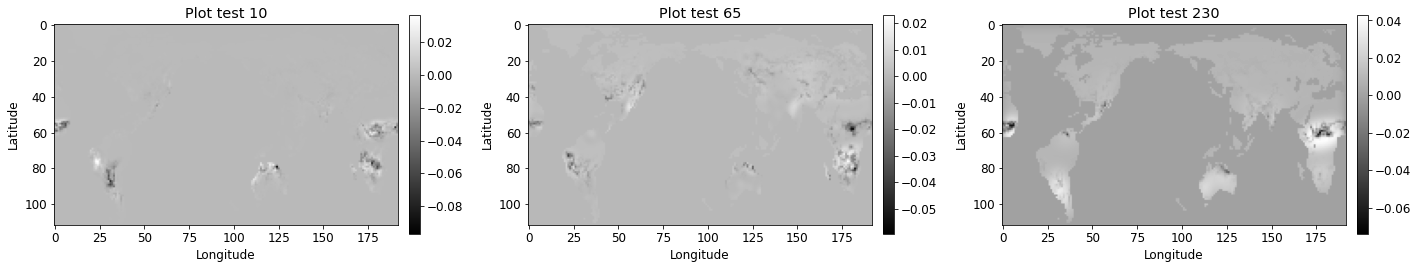

In [53]:
#Area burnt 
print("____________ Real images of area burnt________________")
plot_data_img(1, 3, data = area_burnt_pt_m[60:], true_data=area_burnt_pt_m[60:], ts=[10, 65, 230], title='Area burnt Testing image', threshold=0.012)

print("____________ Predictions multi CNN LSTM 12 to 12 _____________ ")
plot_data_img(1, 3, data = cnnarea_burnt_pred_pT, true_data= area_burnt_pt_m[60:], ts = [10, 65, 230], title='t = ', threshold=0.012)

print("____________ Difference between both _____________ ")
plot_data_img_diff(1, 3, data1 = area_burnt_pt_m[60:], data2 = cnnarea_burnt_pred_pT, ts = [10, 65, 230])

# Results

In [ ]:
pd.set_option('display.float_format', '{:.2e}'.format)

pd.DataFrame([results_bestCAE_pT_ft, results_bestCAE_pT_wft],
             index=['CAE LSTM fine tuned', 'CAE LSTM original',]
             ).sort_values("relative error")

,Time for predictions (s),relative error,mean SSIM
CAE LSTM fine tuned,8.44e+00,2.01e-03,9.87e+01
CAE LSTM original,8.44e+00,2.13e-03,9.85e+01


In [ ]:
pd.DataFrame([results_bestCNN_ft, results_bestCNN_wft],
             index=['Conv LSTM fine tuned', 'Conv LSTM original']
             ).sort_values("relative error")

,Time for predictions (s),relative error,mse_test
Conv LSTM fine tuned,8.44e+00,1.56e-03,1.58e-05
Conv LSTM original,8.71e+00,1.73e-03,1.94e-05


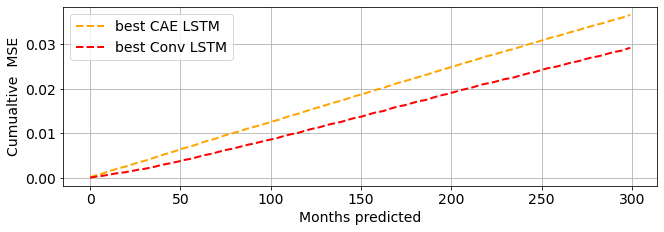

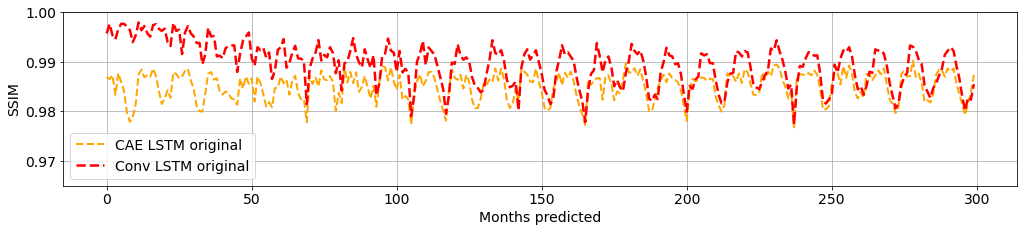

In [63]:
xlim=300
plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(10,4))
# plt.plot(np.arange(0,xlim,1), sumRE_bestCAE_ft[:xlim], '--', label='CAE LSTM fine tuned', linewidth=2.5)
plt.plot(np.arange(0,xlim,1), sumRE_bestCAE_wft[:xlim],  color='orange', linestyle='dashed', label='best CAE LSTM', linewidth=2)
# plt.plot(np.arange(0,xlim,1), sumRE_bestCNN_ft[:xlim], '--', label='Conv LSTM fine tuned', linewidth=2.5)
plt.plot(np.arange(0,xlim,1), sumRE_bestCNN_wft[:xlim],color='red', linestyle='dashed',  label='best Conv LSTM', linewidth=2)
# plt.title('Cumulative sum of the RE')
plt.xlabel('Months predicted')
plt.ylabel('Cumualtive  MSE')
plt.grid(True)
plt.legend()
plt.tight_layout(pad=2.5)
plt.savefig("/content/drive/MyDrive/Wildfires_IRP/Figures/SSIM_1.png", dpi=300)
plt.show()

plt.figure(figsize=(15,4))
# plt.plot(np.arange(0,xlim,1), ssim_bestCAE_ft[:xlim], '--', label='CAE LSTM fine tuned', linewidth=2.5)
plt.plot(np.arange(0,xlim,1), ssim_bestCAE_wtf[:xlim], color='orange', linestyle='dashed', label='CAE LSTM original', linewidth=2)
# plt.plot(np.arange(0,xlim,1), ssim_bestCNN_ft[:xlim], '--', label='Conv LSTM fine tuned', linewidth=2.5)
plt.plot(np.arange(0,xlim,1), ssim_bestCNN_wft[:xlim], color='red', linestyle='dashed', label='Conv LSTM original', linewidth=2.5)
# plt.title('SSIM')
plt.ylim(0.965,1)
plt.xlabel('Months predicted')
plt.ylabel('SSIM')
plt.grid(True)
plt.legend()
plt.tight_layout(pad=2.5)
plt.savefig("/content/drive/MyDrive/Wildfires_IRP/Figures/SSIM_2.png", dpi=300)
plt.show()